# MNIST master

For a demo we shall solve the same digit recognition problem, but at a different scale
* images are now 28x28
* 10 different digits
* 50k samples

Before doing this homework, read some code examples written in tensorflow. There is a good repository with code examples: https://github.com/aymericdamien/TensorFlow-Examples. As we already know, we need many samples to learn :)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

/home/hov/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print(X_train.shape,y_train.shape)

(50000, 1, 28, 28) (50000,)


In [4]:
X_train.shape

(50000, 1, 28, 28)

4

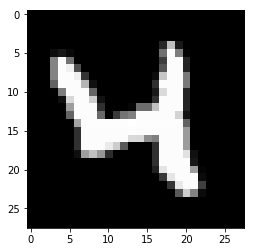

In [9]:
plt.imshow(-X_train[20, 0], cmap="gray_r")
y_train[20]

In [28]:
#defining placeholders for input and target
input_X = tf.placeholder(tf.float32, shape=[None, 1, 28, 28], 
                         name="X")
target_y = tf.placeholder(tf.int32, shape=[None], 
                          name="target_Y_integer")

Defining network architecture

In [29]:
# flatten images to (batch_size x 728) matrix
input_X_reshaped = tf.reshape(input_X, shape=[-1, 1*28*28], 
                              name="reshape_X")

# Fully connected layer, that takes input layer and applies 50 neurons 
# to it. Nonlinearity here is sigmoid as in logistic regression.
# You can give a name to each layer (optional)
l1 = tf.layers.dense(input_X_reshaped, units=50, 
                     activation=tf.nn.sigmoid)

# Fully connected output layer that takes l1 as input and has 
# 10 neurons (1 for each digit).
# This predicts scores for the classes
l2 = tf.layers.dense(l1, units=10, activation=None)

# We use softmax nonlinearity to make probabilities add up to 1
l_out = tf.nn.softmax(l2)

# Prediction
y_predicted = tf.argmax(l2, axis=-1)

In [30]:
weights = tf.trainable_variables()
weights

[<tf.Variable 'dense/kernel:0' shape=(784, 50) dtype=float32_ref>,
 <tf.Variable 'dense/bias:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'dense_1/kernel:0' shape=(50, 10) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32_ref>]

### Than you could simply
* define loss function manually
* compute error gradient over all weights
* define updates
* But that's a whole lot of work and life's short
  * not to mention life's too short to wait for SGD to converge

Instead, we shall use Tensorflow builtins

In [31]:
# Mean categorical crossentropy as a loss function
# - similar to logistic loss but for multiclass targets
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=target_y, logits=l2, name="softmax_loss"))

In [32]:
accuracy, update_accuracy = tf.metrics.accuracy(target_y, y_predicted)
tf.local_variables()

[<tf.Variable 'accuracy/total:0' shape=() dtype=float32_ref>,
 <tf.Variable 'accuracy/count:0' shape=() dtype=float32_ref>]

In [33]:
optimzer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_step = optimzer.minimize(loss)

### That's all, now let's train it!
* We got a lot of data, so it's recommended that you use SGD
* So let's implement a function that splits the training sample into minibatches

In [34]:
# An auxilary function that returns mini-batches for neural network training

#Parameters
# inputs - a tensor of images with shape (many, 1, 28, 28), e.g. X_train
# outputs - a vector of answers for corresponding images e.g. Y_train
#batch_size - a single number - the intended size of each batches

def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

# Training loop

Model saver.
<br>
See more:
http://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/

In [35]:
model_path = "./checkpoints/model.ckpt"
saver = tf.train.Saver(max_to_keep=3)

In [36]:
import time

num_epochs = 100 # amount of passes through the data

batch_size = 50 # number of samples processed at each function call

with tf.Session() as sess:
    # initialize global wariables
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()

        sess.run(tf.local_variables_initializer())
        for batch in iterate_minibatches(X_train, y_train,batch_size):
            inputs, targets = batch

            _, train_err_batch, _ = sess.run(
                [train_step, loss, update_accuracy], 
                feed_dict={input_X: inputs, target_y:targets}
            )
            train_err += train_err_batch
            train_batches += 1
        train_acc = sess.run(accuracy)

        # And a full pass over the validation data:
        sess.run(tf.local_variables_initializer())
        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            sess.run(update_accuracy, feed_dict={input_X: inputs, 
                                                 target_y:targets})
        val_acc = sess.run(accuracy)


        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))

        print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(
            train_acc * 100))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc * 100))
        
        # save model
        save_path = saver.save(sess, model_path, global_step=epoch)
        print("  Model saved in file: %s" % save_path)

Epoch 1 of 100 took 2.053s
  training loss (in-iteration):		1.853357
  train accuracy:		59.01 %
  validation accuracy:		76.75 %
  Model saved in file: ./checkpoints/model.ckpt-0
Epoch 2 of 100 took 1.701s
  training loss (in-iteration):		1.187282
  train accuracy:		78.11 %
  validation accuracy:		83.84 %
  Model saved in file: ./checkpoints/model.ckpt-1
Epoch 3 of 100 took 1.749s
  training loss (in-iteration):		0.852740
  train accuracy:		82.77 %
  validation accuracy:		86.50 %
  Model saved in file: ./checkpoints/model.ckpt-2
Epoch 4 of 100 took 2.149s
  training loss (in-iteration):		0.688422
  train accuracy:		84.98 %
  validation accuracy:		87.58 %
  Model saved in file: ./checkpoints/model.ckpt-3
Epoch 5 of 100 took 1.622s
  training loss (in-iteration):		0.594161
  train accuracy:		86.34 %
  validation accuracy:		88.55 %
  Model saved in file: ./checkpoints/model.ckpt-4
Epoch 6 of 100 took 1.705s
  training loss (in-iteration):		0.532998
  train accuracy:		87.23 %
  validation a

Epoch 47 of 100 took 1.550s
  training loss (in-iteration):		0.243186
  train accuracy:		93.07 %
  validation accuracy:		93.57 %
  Model saved in file: ./checkpoints/model.ckpt-46
Epoch 48 of 100 took 1.744s
  training loss (in-iteration):		0.241218
  train accuracy:		93.13 %
  validation accuracy:		93.57 %
  Model saved in file: ./checkpoints/model.ckpt-47
Epoch 49 of 100 took 1.889s
  training loss (in-iteration):		0.239338
  train accuracy:		93.15 %
  validation accuracy:		93.65 %
  Model saved in file: ./checkpoints/model.ckpt-48
Epoch 50 of 100 took 1.709s
  training loss (in-iteration):		0.237520
  train accuracy:		93.22 %
  validation accuracy:		93.61 %
  Model saved in file: ./checkpoints/model.ckpt-49
Epoch 51 of 100 took 1.739s
  training loss (in-iteration):		0.235726
  train accuracy:		93.25 %
  validation accuracy:		93.75 %
  Model saved in file: ./checkpoints/model.ckpt-50
Epoch 52 of 100 took 1.535s
  training loss (in-iteration):		0.233945
  train accuracy:		93.37 %
  v

Epoch 93 of 100 took 1.597s
  training loss (in-iteration):		0.180535
  train accuracy:		94.77 %
  validation accuracy:		95.07 %
  Model saved in file: ./checkpoints/model.ckpt-92
Epoch 94 of 100 took 1.446s
  training loss (in-iteration):		0.179594
  train accuracy:		94.81 %
  validation accuracy:		95.10 %
  Model saved in file: ./checkpoints/model.ckpt-93
Epoch 95 of 100 took 1.359s
  training loss (in-iteration):		0.178596
  train accuracy:		94.84 %
  validation accuracy:		95.09 %
  Model saved in file: ./checkpoints/model.ckpt-94
Epoch 96 of 100 took 1.390s
  training loss (in-iteration):		0.177648
  train accuracy:		94.84 %
  validation accuracy:		95.11 %
  Model saved in file: ./checkpoints/model.ckpt-95
Epoch 97 of 100 took 1.533s
  training loss (in-iteration):		0.176731
  train accuracy:		94.87 %
  validation accuracy:		95.13 %
  Model saved in file: ./checkpoints/model.ckpt-96
Epoch 98 of 100 took 1.558s
  training loss (in-iteration):		0.175767
  train accuracy:		94.92 %
  v

Now we can restore saved parameters:

In [37]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    load_path = saver.restore(sess, saver.last_checkpoints[-1])
    print("Model restored from file: %s" % save_path)
    
    sess.run(tf.local_variables_initializer())
    for batch in iterate_minibatches(X_test, y_test, 500):
        inputs, targets = batch
        sess.run(update_accuracy, feed_dict={input_X: inputs, 
                                                   target_y:targets})
    test_acc = sess.run(accuracy)
    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc* 100))

    if test_acc * 100 > 99.5:
        print ("Achievement unlocked: 80lvl Warlock!")
    else:
        print ("We need more magic!")

INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-99
Model restored from file: ./checkpoints/model.ckpt-99
Final results:
  test accuracy:		94.89 %
We need more magic!


# Now improve it!

* Moar layers!
* Moar units!
* Different nonlinearities!